In [1]:
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd

from enzy_pred import *

import warnings
warnings.filterwarnings("ignore")
logger.setLevel(logging.INFO)

2022-04-25 17:02:35.789340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 17:02:35.789371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-25 17:02:39,586 git.cmd DEBUG Popen(['git', 'version'], cwd=/home/cz332/synthetic-network, universal_newlines=False, shell=None, istream=None)
2022-04-25 17:02:39,604 git.cmd DEBUG Popen(['git', 'version'], cwd=/home/cz332/synthetic-network, universal_newlines=False, shell=None, istream=None)


# ECFPS

In [3]:
enz = EnzymePrediction()
enz.main()

In [4]:
data = enz.Xs.iloc[:,0:32]
data['y'] = list(enz.ECs.loc[data.index.get_level_values(0)][0])

In [5]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(data.iloc[:,0:32])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3733 samples in 0.044s...
[t-SNE] Computed neighbors for 3733 samples in 0.822s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3733
[t-SNE] Computed conditional probabilities for sample 2000 / 3733
[t-SNE] Computed conditional probabilities for sample 3000 / 3733
[t-SNE] Computed conditional probabilities for sample 3733 / 3733
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.557915
[t-SNE] KL divergence after 1000 iterations: 1.372581


[Text(0.5, 1.0, 'KEGG reaction data T-SNE projection')]

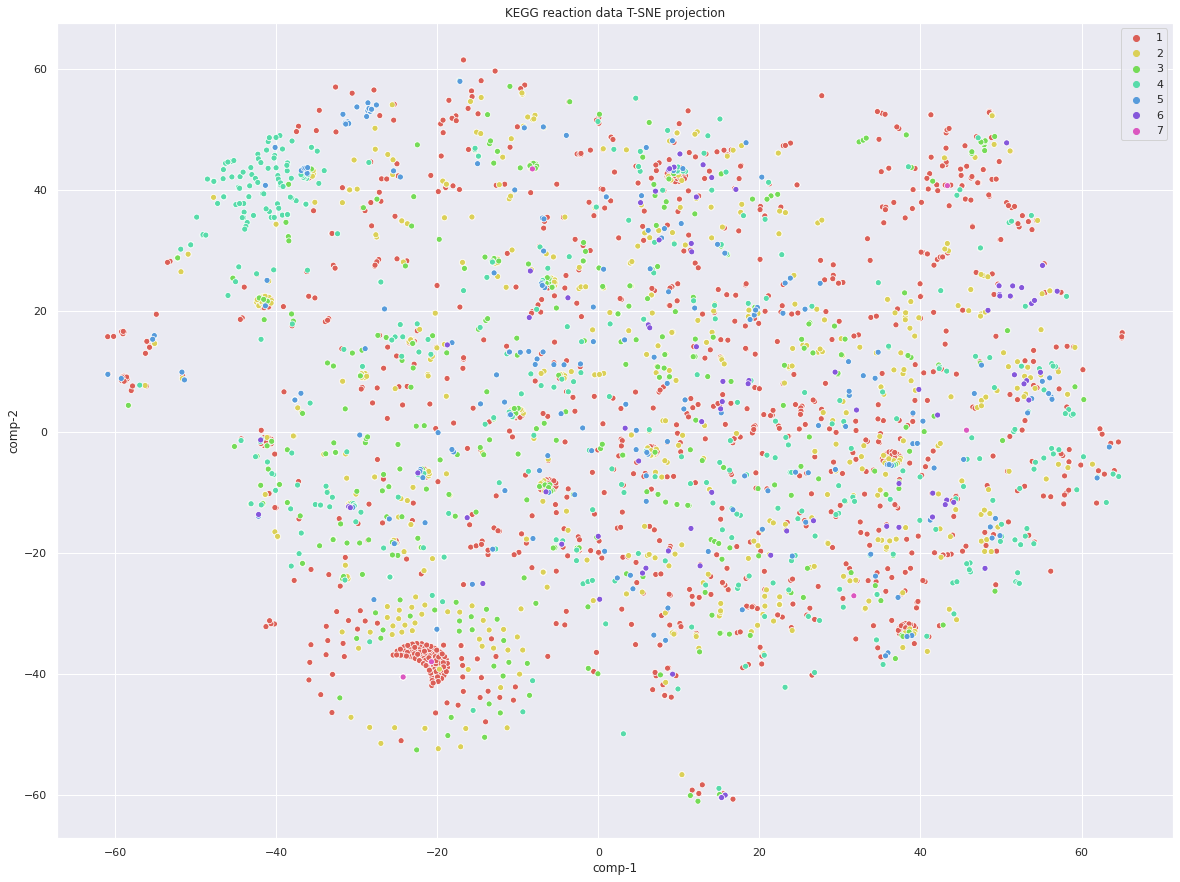

In [11]:
df = pd.DataFrame()
df["y"] = list(data['y'])
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.set(rc={'figure.figsize':(20,15)})
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="KEGG reaction data T-SNE projection")

# BRET FPS

In [12]:
enz.data['react_smiles'] = list(enz.data['react'].apply(lambda x: enz.mols.loc[x].SMILES))
enz.data['prod_smiles'] = list(enz.data['prod'].apply(lambda x: enz.mols.loc[x].SMILES))

In [13]:
def rxn_fp(r,p):
    return r+'>>'+p

In [14]:
rxn_smiles = []
for index, row in enz.data.iterrows():
    rxn_smiles.append(rxn_fp(row.react_smiles, row.prod_smiles))

    

In [15]:
from rxnfp.transformer_fingerprints import (
    RXNBERTFingerprintGenerator, get_default_model_and_tokenizer, generate_fingerprints
)

model, tokenizer = get_default_model_and_tokenizer()

rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)

fps = rxnfp_generator.convert_batch(rxn_smiles)
print(len(fps), len(fps[0]))

3733 256


In [16]:
fps = pd.DataFrame(fps)
fps.index = data.index

In [17]:
fps

0         1         2         3         4         5    \
EC      RXN                                                                  
1.1.1.1 R00623 -0.919668 -2.039001  0.629600 -3.119359  1.278849 -0.888024   
        R00624 -0.473382 -0.945047 -0.330846 -2.066775  1.397656 -1.204910   
1.1.1.2 R07328 -0.933331 -1.897175  0.822847 -2.594280  1.606007 -1.720127   
1.1.1.3 R01773 -0.613653  0.070542  0.978965 -1.459088  0.121487  0.368077   
        R01775 -0.613653  0.070542  0.978965 -1.459088  0.121487  0.368077   
...                  ...       ...       ...       ...       ...       ...   
7.1.1.7 R11886 -0.416386 -0.724190  0.370776 -0.800764  2.026269 -1.478724   
7.2.4.1 R09509 -1.531649 -0.976572 -1.079012 -1.711665  1.991526  0.426822   
7.2.4.2 R12212 -1.400874 -0.207985 -2.592524 -1.162146  2.173787 -2.984922   
7.2.4.5 R03028 -1.531372  0.752323 -2.953766  0.007814  2.191412 -2.509349   
7.3.2.6 R10531 -1.057826 -2.468548 -0.568719 -1.905072  0.971325 -0.644266   

                     6         7         8         9    ...       246  \
EC      RXN                                             ...             
1.1.1.1 R00623 -0.144347  1.083798 -3.527989  0.121589  ... -1.668922   
        R00624  0.187902  1.894083 -2.008309 -1.710086  ... -1.163378   
1.1.1.2 R07328  0.065376  0.346227 -2.635670  0.244600  ... -1.167283   
1.1.1.3 R01773  0.845439  0.154782 -2.051017 -2.689778  ... -1.055542   
        R01775  0.845439  0.154782 -2.051017 -2.689778  ... -1.055542   
...                  ...       ...       ...       ...  ...       ...   
7.1.1.7 R11886 -1.134454 -0.127199 -3.338356 -0.055725  ... -0.151511   
7.2.4.1 R09509  0.835890  0.924845 -0.737034  1.700835  ...  0.119870   
7.2.4.2 R12212  0.090217  1.315507 -0.566300  0.924461  ... -0.670430   
7.2.4.5 R03028  0.199464  1.637158  0.546962  1.680245  ...  0.040636   
7.3.2.6 R10531 -1.125179 -0.051111 -1.670203  0.502761  ... -1.529249   

                     247       248       249       250       251       252  \
EC      RXN                                                                  
1.1.1.1 R00623 -0.280305  1.484184  0.102906  3.558177 -0.446494 -1.041084   
        R00624 -0.668381  0.668851  0.305467  1.823569 -0.689222 -0.689910   
1.1.1.2 R07328 -0.097803  2.045503 -0.360437  3.232266  0.102161 -1.327533   
1.1.1.3 R01773  0.879918 -1.481573  1.253192  0.964916 -0.416735  0.756191   
        R01775  0.879918 -1.481573  1.253192  0.964916 -0.416735  0.756191   
...                  ...       ...       ...       ...       ...       ...   
7.1.1.7 R11886  1.210252  1.260817 -1.280736  0.732677  0.197025 -1.395815   
7.2.4.1 R09509  1.460821  2.498396  0.015798  1.507937  0.257101 -1.365233   
7.2.4.2 R12212  0.105853  2.524484 -0.806839  1.638636 -0.723754 -1.711754   
7.2.4.5 R03028 -0.751870  1.950025 -0.612566  1.789388 -0.353634 -1.588634   
7.3.2.6 R10531  2.274869  2.203380  0.498598  0.708578  0.183388 -0.922530   

                     253       254       255  
EC      RXN                                   
1.1.1.1 R00623  0.784960 -0.114390 -1.067846  
        R00624  1.631112 -0.108997 -0.226428  
1.1.1.2 R07328  0.577196 -0.134367 -1.666155  
1.1.1.3 R01773  1.952698  0.147805 -1.086681  
        R01775  1.952698  0.147805 -1.086681  
...                  ...       ...       ...  
7.1.1.7 R11886 -0.126954  0.378330 -0.926402  
7.2.4.1 R09509  1.945794 -0.242332 -0.728300  
7.2.4.2 R12212  0.920618 -0.058679 -1.681281  
7.2.4.5 R03028  1.524936  0.315752 -0.970587  
7.3.2.6 R10531  1.949752 -0.077011 -0.516790  

[3733 rows x 256 columns]

# TSNE

In [150]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, early_exaggeration=12, init='random', random_state=1)
z = tsne.fit_transform(fps)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3733 samples in 0.132s...
[t-SNE] Computed neighbors for 3733 samples in 6.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3733
[t-SNE] Computed conditional probabilities for sample 2000 / 3733
[t-SNE] Computed conditional probabilities for sample 3000 / 3733
[t-SNE] Computed conditional probabilities for sample 3733 / 3733
[t-SNE] Mean sigma: 3.221643
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.434822
[t-SNE] KL divergence after 1000 iterations: 0.764722


In [151]:
df = pd.DataFrame()
df["y"] = list(data['y'])
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
# df["comp-3"] = z[:,2]

[Text(0.5, 1.0, 'KEGG reaction data BRET fps T-SNE projection')]

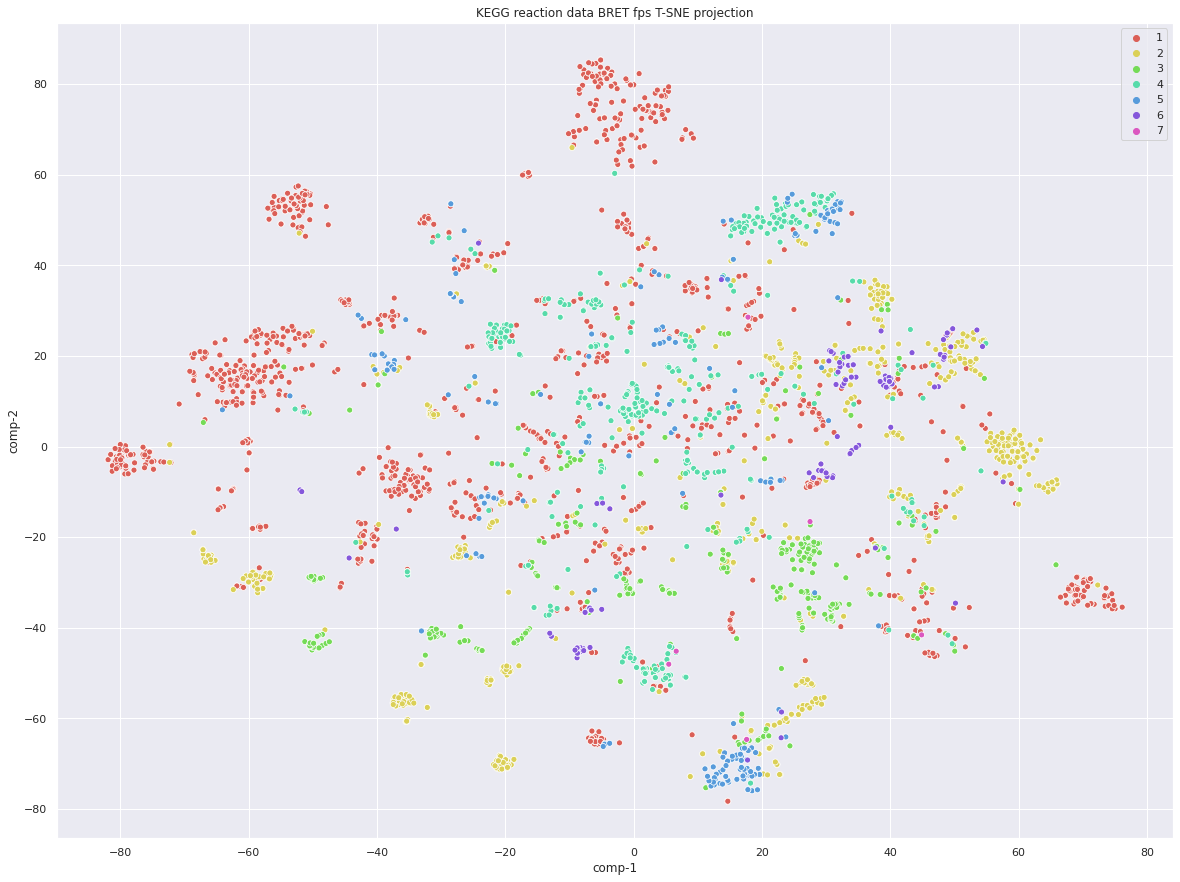

In [152]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="KEGG reaction data BRET fps T-SNE projection")

[Text(0.5, 1.0, 'KEGG reaction data BRET fps T-SNE projection')]

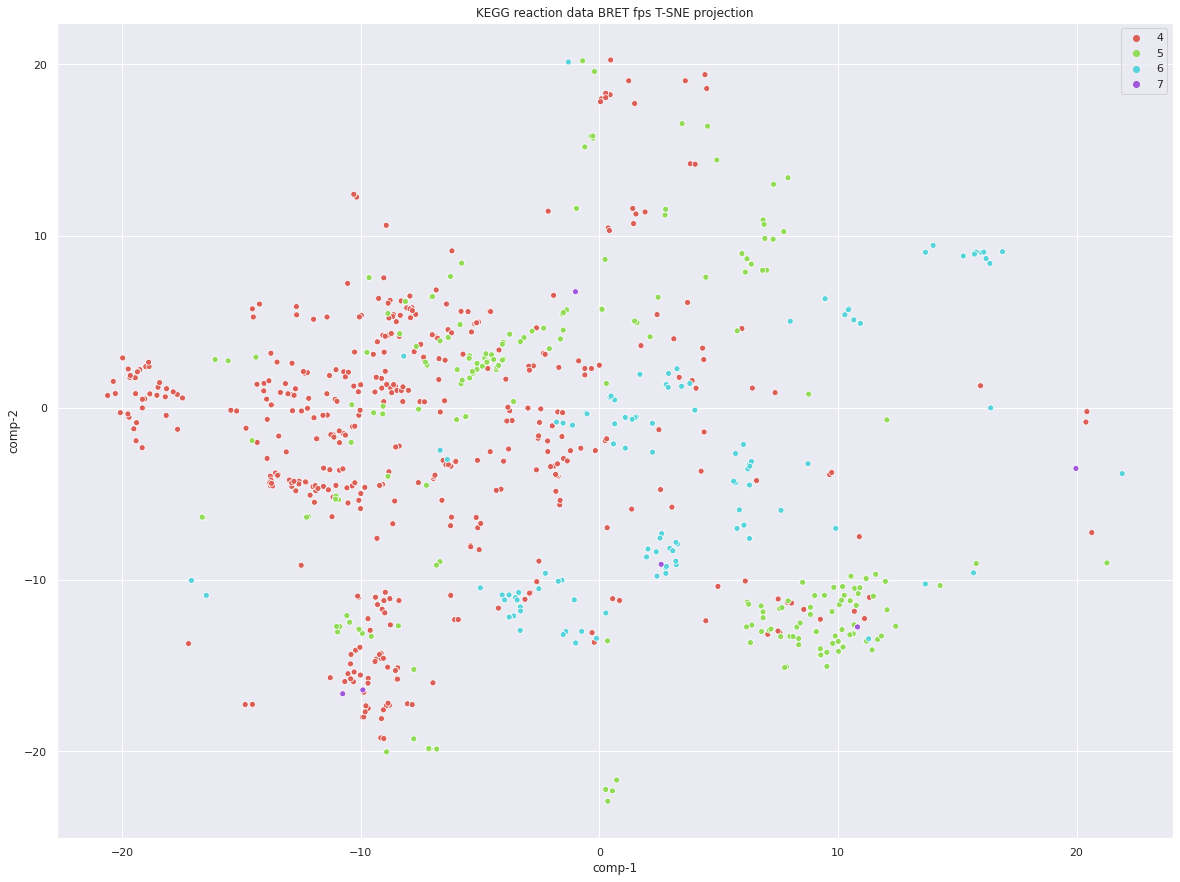

In [95]:
df123 = df[df['y'].isin([4,5,6,7])]
sns.scatterplot(x="comp-1", y="comp-2", hue=df123.y.tolist(),
                palette=sns.color_palette("hls", len(df123.y.unique())),
                data=df123).set(title="KEGG reaction data BRET fps T-SNE projection")

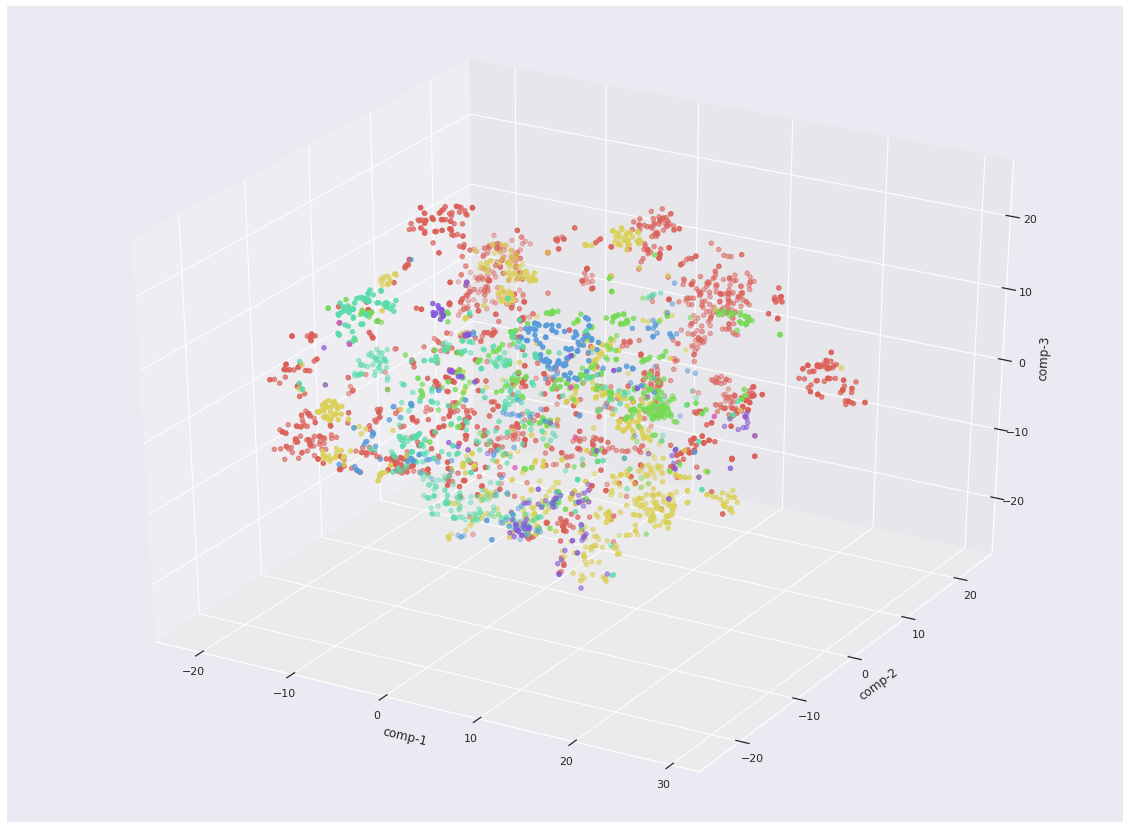

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')


ax.set_xlabel("comp-1")
ax.set_ylabel("comp-2")
ax.set_zlabel("comp-3")

cmap = ListedColormap(sns.color_palette("hls", 7).as_hex())
ax.scatter(df["comp-1"] , df["comp-2"] , df["comp-3"], cmap=cmap, c=df.y.tolist())


plt.show()

# ISOMAP

In [134]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
z = embedding.fit_transform(fps)

In [135]:
df = pd.DataFrame()
df["y"] = list(data['y'])
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
# df["comp-3"] = z[:,2]

[Text(0.5, 1.0, 'KEGG reaction data BRET fps ISOMAP projection')]

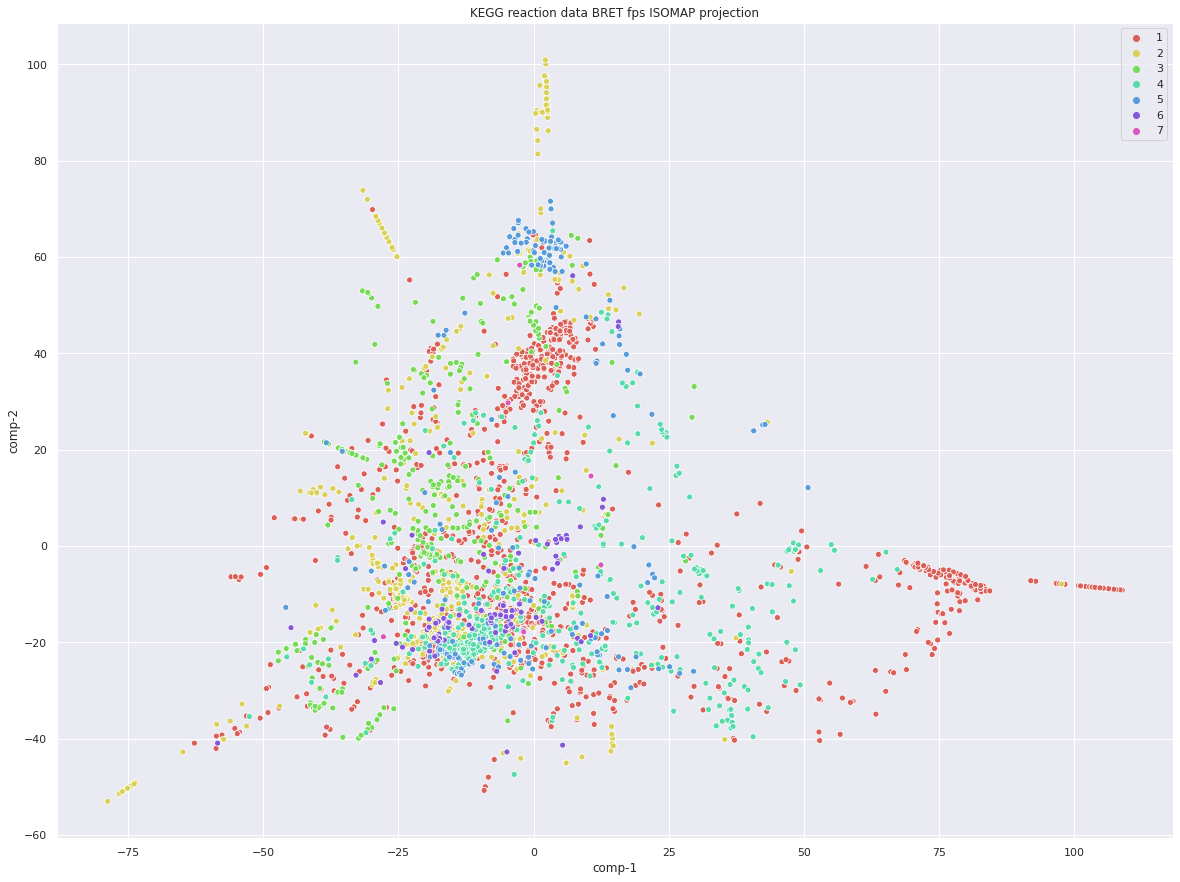

In [136]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="KEGG reaction data BRET fps ISOMAP projection")

# Predicted reaction TSNE chemical space

In [154]:
pred_rxn = load_pred_rxn_db()
pred_rxn

,react,prod,enzyme_name,reaction_formula,pred_origin,direct,react_smiles,prod_smiles
PR1,C00002,PC1,NaN,NaN,R00429,-1,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,O=P(O)(O)OP(=O)(O)Nc1ncnc2c1ncn2C1OC(COP(=O)(O...
PR2,C00002,PC2,NaN,NaN,R09394,-1,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...
PR3,C00002,PC3,NaN,NaN,R01856,-1,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,Nc1ncnc2c1ncn2C1OC(CO)C(O)C1O
PR4,C00004,PC4,NaN,NaN,R00112,-1,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OCC2OC(N...
PR5,PC5,C00004,NaN,NaN,R00257,1,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OCC2OC(N...,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...
...,...,...,...,...,...,...,...,...
PR12418,PC3641,C22243,NaN,NaN,R09632,1,CC1OC(O)C(O)C(OCC2OC(CO)C(O)C(O)C2O)C1O,CO[C@@H]1[C@@H](O)[C@H](C)OC(O)[C@@H]1O
PR12419,C22243,PC6659,NaN,NaN,R03161,-1,CO[C@@H]1[C@@H](O)[C@H](C)OC(O)[C@@H]1O,CC1OC(O)C(O)C(OCP(=O)(O)O)C1O
PR12420,C22244,PC1867,NaN,NaN,R02438,-1,C[C@@H]1OC(O)[C@H](O)C[C@H]1O,CC1OC(O)C(O)CC1O
PR12421,PC1869,C22244,NaN,NaN,R09632,1,OCC1OC(CC2OC(O)C(O)CC2O)C(O)C(O)C1O,C[C@@H]1OC(O)[C@H](O)C[C@H]1O


In [155]:
pred_rxn.pred_origin

PR1        R00429
PR2        R09394
PR3        R01856
PR4        R00112
PR5        R00257
            ...  
PR12418    R09632
PR12419    R03161
PR12420    R02438
PR12421    R09632
PR12422    R03161
Name: pred_origin, Length: 12422, dtype: object

In [195]:
ecs = pd.DataFrame(data={'EC':enz.ECs.loc[data.index.get_level_values(0).tolist()][0].tolist()},index=data.index.get_level_values(1).tolist())

In [241]:
# remove rows with duplicated indices in ecs
index = ecs.index
is_duplicate = index.duplicated(keep="first")
not_duplicate = ~is_duplicate
ecs = ecs[not_duplicate]

In [243]:
possible_rxn = set([rxn for rxn in pred_rxn.pred_origin if rxn in ecs.index])

In [244]:
possible_pred_rxn = pred_rxn[pred_rxn.pred_origin.isin(possible_rxn)]

In [248]:
possible_pred_rxn['ec'] = ecs.loc[possible_pred_rxn.pred_origin].EC.tolist()

In [250]:
possible_pred_rxn

,react,prod,enzyme_name,reaction_formula,pred_origin,direct,react_smiles,prod_smiles,ec
PR1,C00002,PC1,NaN,NaN,R00429,-1,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,O=P(O)(O)OP(=O)(O)Nc1ncnc2c1ncn2C1OC(COP(=O)(O...,2
PR2,C00002,PC2,NaN,NaN,R09394,-1,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,4
PR3,C00002,PC3,NaN,NaN,R01856,-1,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,Nc1ncnc2c1ncn2C1OC(CO)C(O)C1O,3
PR4,C00004,PC4,NaN,NaN,R00112,-1,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OCC2OC(N...,1
PR5,PC5,C00004,NaN,NaN,R00257,1,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OCC2OC(N...,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,6
...,...,...,...,...,...,...,...,...,...
PR12416,C22242,PC6659,NaN,NaN,R03161,-1,CO[C@@H]1[C@H](O)C(O)O[C@H](C)[C@H]1O,CC1OC(O)C(O)C(OCP(=O)(O)O)C1O,2
PR12418,PC3641,C22243,NaN,NaN,R09632,1,CC1OC(O)C(O)C(OCC2OC(CO)C(O)C(O)C2O)C1O,CO[C@@H]1[C@@H](O)[C@H](C)OC(O)[C@@H]1O,2
PR12419,C22243,PC6659,NaN,NaN,R03161,-1,CO[C@@H]1[C@@H](O)[C@H](C)OC(O)[C@@H]1O,CC1OC(O)C(O)C(OCP(=O)(O)O)C1O,2
PR12421,PC1869,C22244,NaN,NaN,R09632,1,OCC1OC(CC2OC(O)C(O)CC2O)C(O)C(O)C1O,C[C@@H]1OC(O)[C@H](O)C[C@H]1O,2


In [255]:
pred_rxn_smiles = []
for index, row in possible_pred_rxn.iterrows():
    pred_rxn_smiles.append(rxn_fp(row.react_smiles, row.prod_smiles))

rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)

pred_fps = rxnfp_generator.convert_batch(pred_rxn_smiles)
print(len(pred_fps), len(pred_fps[0]))


pred_fps = pd.DataFrame(pred_fps)
fps.index = data.index

4476 256


In [256]:
pred_fps

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-1.373245,-0.413876,-0.657643,-1.222029,0.526508,-0.165076,-2.748076,0.122614,-2.009877,2.880747,...,-1.030791,2.622440,0.120243,0.860459,2.056800,0.000973,-1.447745,-0.393692,1.033824,0.502765
1,-1.066984,-2.272388,-0.546908,-1.772599,0.863064,-0.613048,-1.148047,-0.055339,-1.633918,0.585657,...,-1.472922,2.224573,2.291693,0.403023,0.639433,0.122046,-0.920760,1.995478,-0.026605,-0.479773
2,-0.370684,-1.344300,-0.114861,-0.823014,1.778743,-1.290440,-0.950633,0.526701,-1.371497,0.816898,...,0.365838,0.819854,1.367461,-1.107893,1.747334,0.298995,-1.700565,-0.792575,0.383422,-0.230748
3,-1.134369,-0.267368,0.088612,-0.734849,1.602758,-1.240287,-1.033030,1.667684,-1.361616,1.220447,...,-0.322519,0.975749,0.417073,0.178847,1.910958,-0.826345,-0.960902,0.130288,1.617290,0.155172
4,-2.446210,-0.396557,-1.296106,-0.402416,0.805720,-1.321222,-1.445116,0.019901,0.730191,1.043543,...,-1.315438,-1.752441,1.488525,-0.416332,2.089984,-1.413911,-0.467176,0.403336,0.734768,-0.533624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4471,-0.566845,-0.304685,0.522838,-1.220401,1.169457,-1.364719,-0.039810,1.769508,-0.901584,1.447920,...,-0.175755,0.114402,2.404928,-0.810450,1.863595,-0.738930,-2.012732,-1.249110,-1.341245,0.207494
4472,0.331627,-0.652788,0.271081,-1.265446,1.596457,-0.710855,0.631502,2.790049,-1.252123,1.363650,...,0.743590,-1.014624,1.223788,-0.195623,2.423889,-0.955874,-1.140116,0.382221,-1.234737,0.654334
4473,-0.596338,-0.323274,0.689163,-1.167647,1.176168,-1.481233,0.079638,1.694895,-0.736220,1.467084,...,-0.231118,-0.089472,2.495677,-0.913723,2.030178,-0.677745,-1.911231,-1.230658,-1.343255,0.178424
4474,-0.540203,-0.920597,-0.268353,-1.507807,2.127932,-1.368399,0.292811,2.286794,-1.118148,1.699235,...,-0.698004,-0.504290,2.344354,0.051541,2.228378,0.168633,-2.086498,0.861959,-2.148058,-0.930687


In [257]:
zz = tsne.fit_transform(pred_fps)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4476 samples in 0.177s...
[t-SNE] Computed neighbors for 4476 samples in 6.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4476
[t-SNE] Computed conditional probabilities for sample 2000 / 4476
[t-SNE] Computed conditional probabilities for sample 3000 / 4476
[t-SNE] Computed conditional probabilities for sample 4000 / 4476
[t-SNE] Computed conditional probabilities for sample 4476 / 4476
[t-SNE] Mean sigma: 2.220180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.202103
[t-SNE] KL divergence after 1000 iterations: 0.536377


[Text(0.5, 1.0, 'KEGG reaction data BRET fps T-SNE projection')]

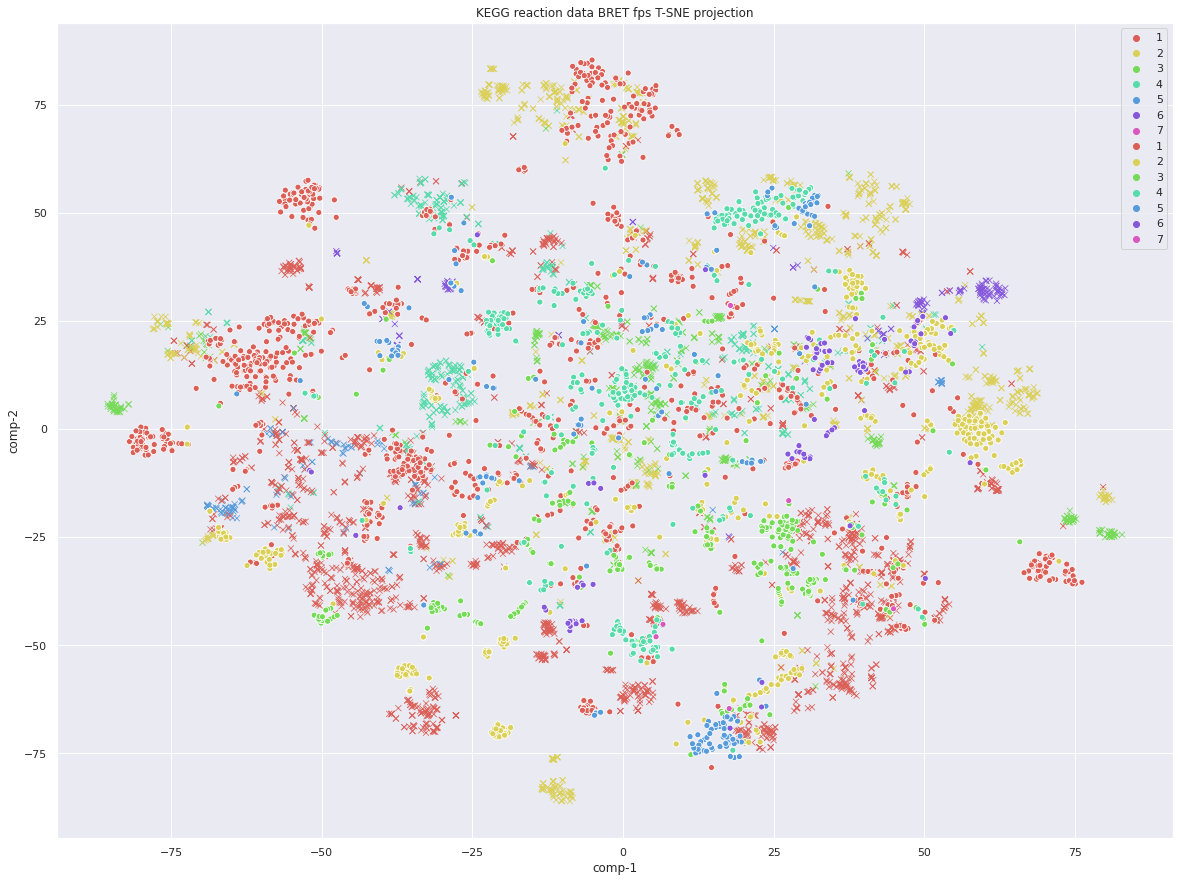

In [267]:
pred_df = pd.DataFrame()

pred_df["y"] = list(possible_pred_rxn['ec'])
pred_df["comp-1"] = zz[:,0]
pred_df["comp-2"] = zz[:,1]
# pred_df["comp-3"] = zz[:,2]
sns.scatterplot(x="comp-1", y="comp-2", hue=pred_df.y.tolist(), marker="x",
                palette=sns.color_palette("hls", 7),
                data=pred_df).set(title="KEGG reaction data BRET fps T-SNE projection")

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="KEGG reaction data BRET fps T-SNE projection")

In [268]:
def select_class(classes):
    
    df_cut = df[df['y'].isin(classes)]
    pred_df_cut = pred_df[pred_df['y'].isin(classes)]
    
    sns.scatterplot(x="comp-1", y="comp-2", hue=df_cut.y.tolist(),
                palette=sns.color_palette("hls", len(df_cut.y.unique())),
                data=df_cut).set(title="KEGG reaction data BRET fps T-SNE projection")
    
    sns.scatterplot(x="comp-1", y="comp-2", hue=pred_df_cut.y.tolist(), marker="x",
                palette=sns.color_palette("hls", len(pred_df_cut.y.unique())),
                data=pred_df_cut).set(title="KEGG reaction data BRET fps T-SNE projection")

In [276]:
def select_one_class(classes):
    
    df_cut = df[df['y'].isin(classes)]
    pred_df_cut = pred_df[pred_df['y'].isin(classes)]
    
    df_cut = df[df['y'].isin(classes)]
    df_cut['y'] = 'original_rxn'
    pred_df_cut = pred_df[pred_df['y'].isin(classes)]
    pred_df_cut['y'] = 'predicted_rxn'
    
    df_concat = pd.concat([df_cut, pred_df_cut])
    
    sns.scatterplot(x="comp-1", y="comp-2", hue=df_concat.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df_concat).set(title="KEGG reaction data BRET fps T-SNE projection for EC{} reactions".format(str(classes[0])))

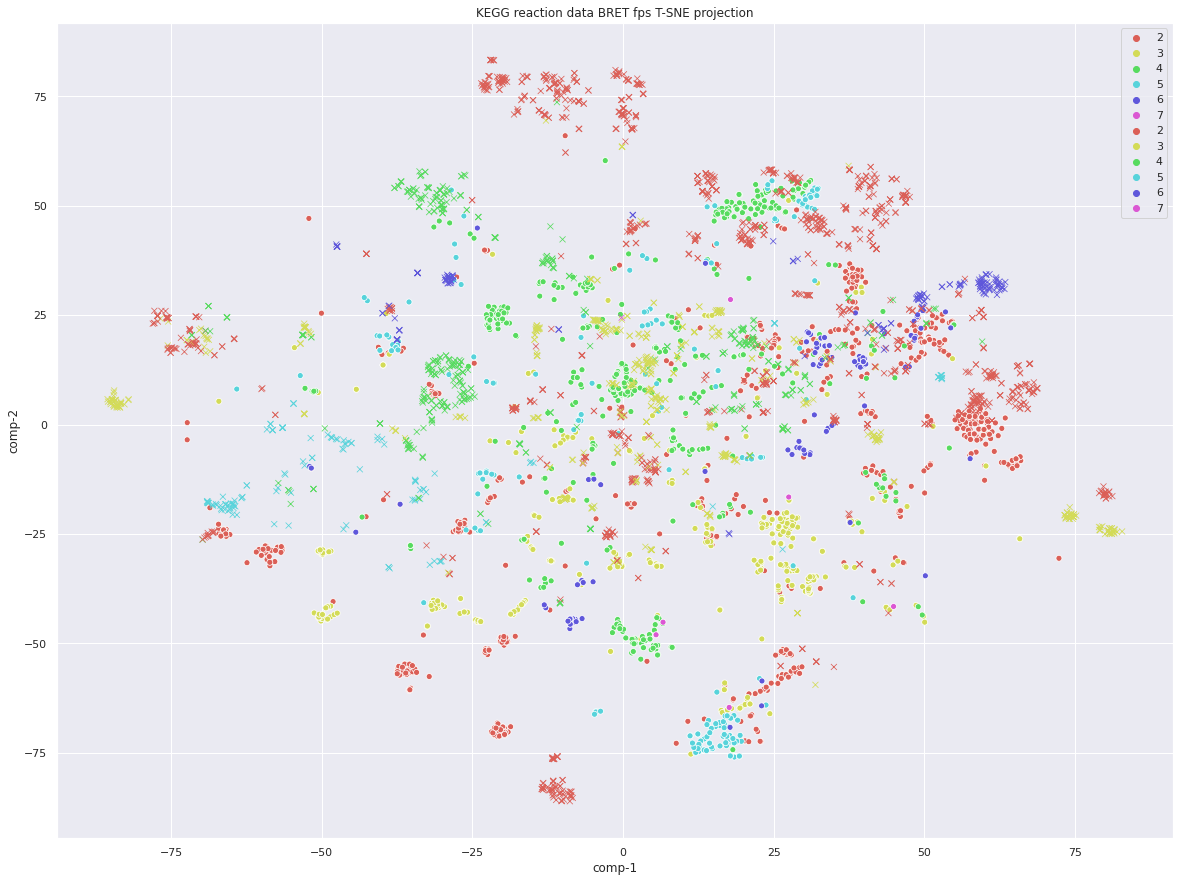

In [283]:
select_class([2,3,4,5,6,7])

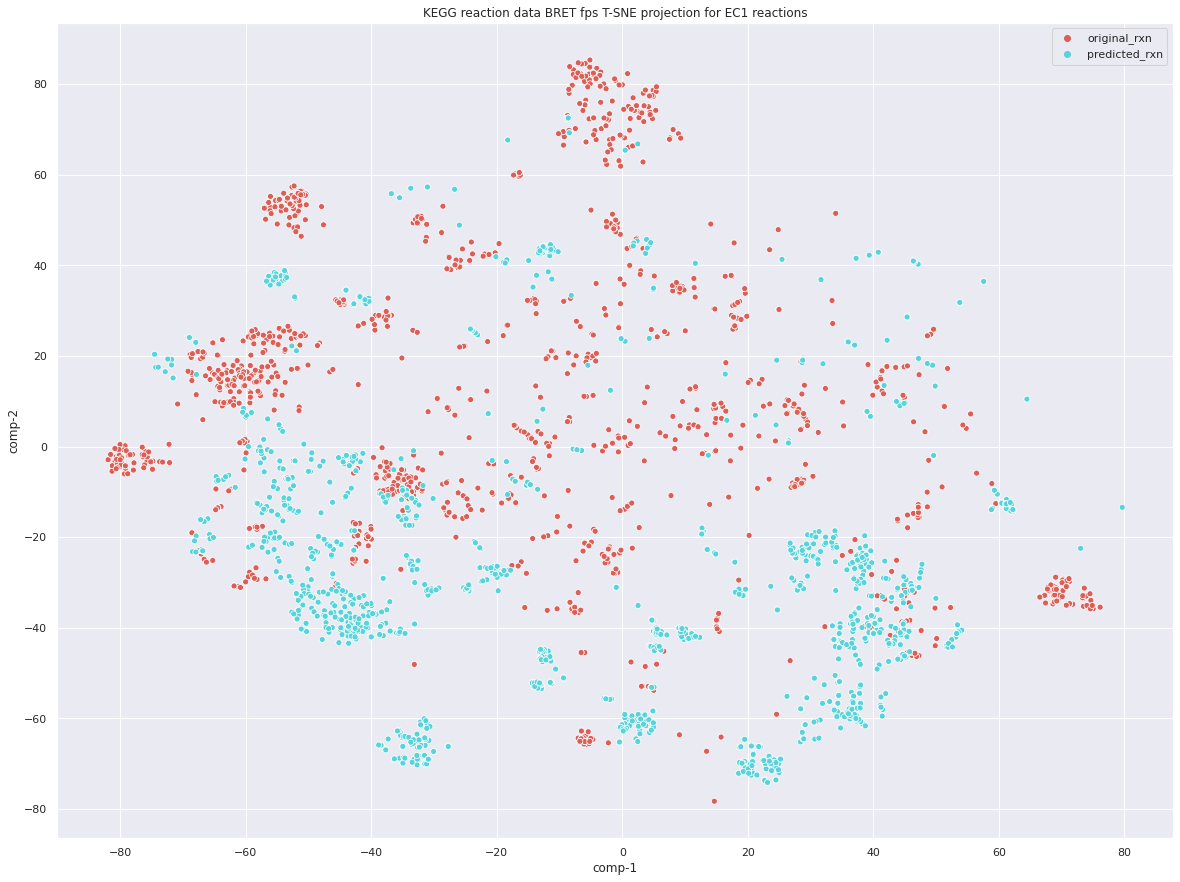

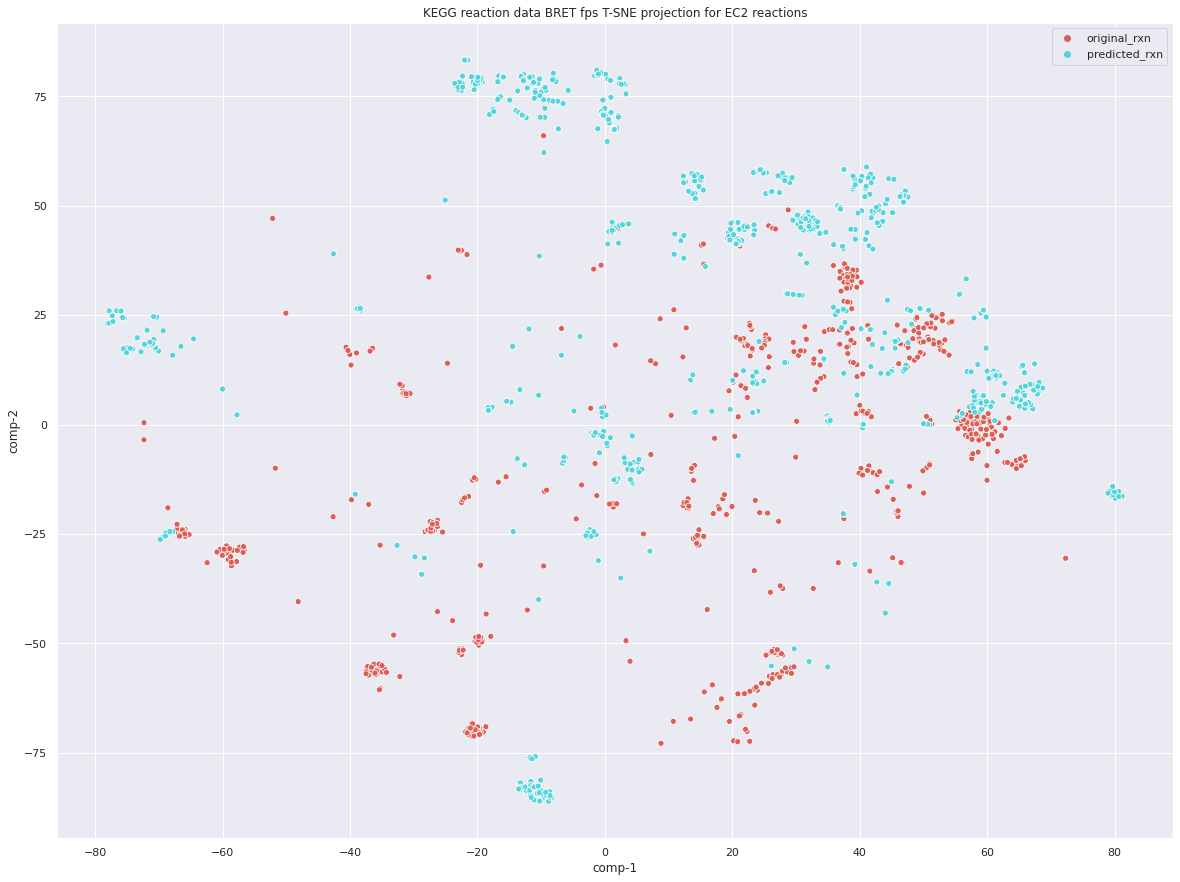

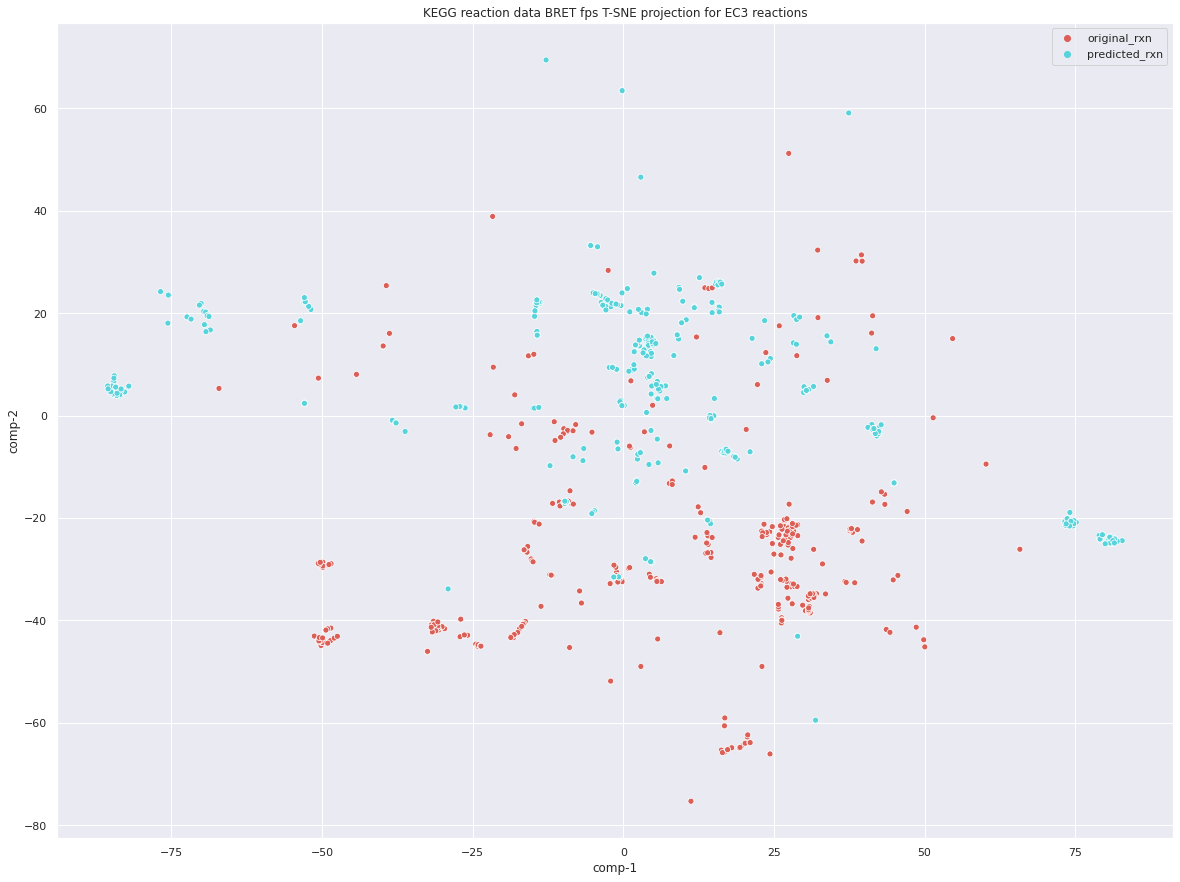

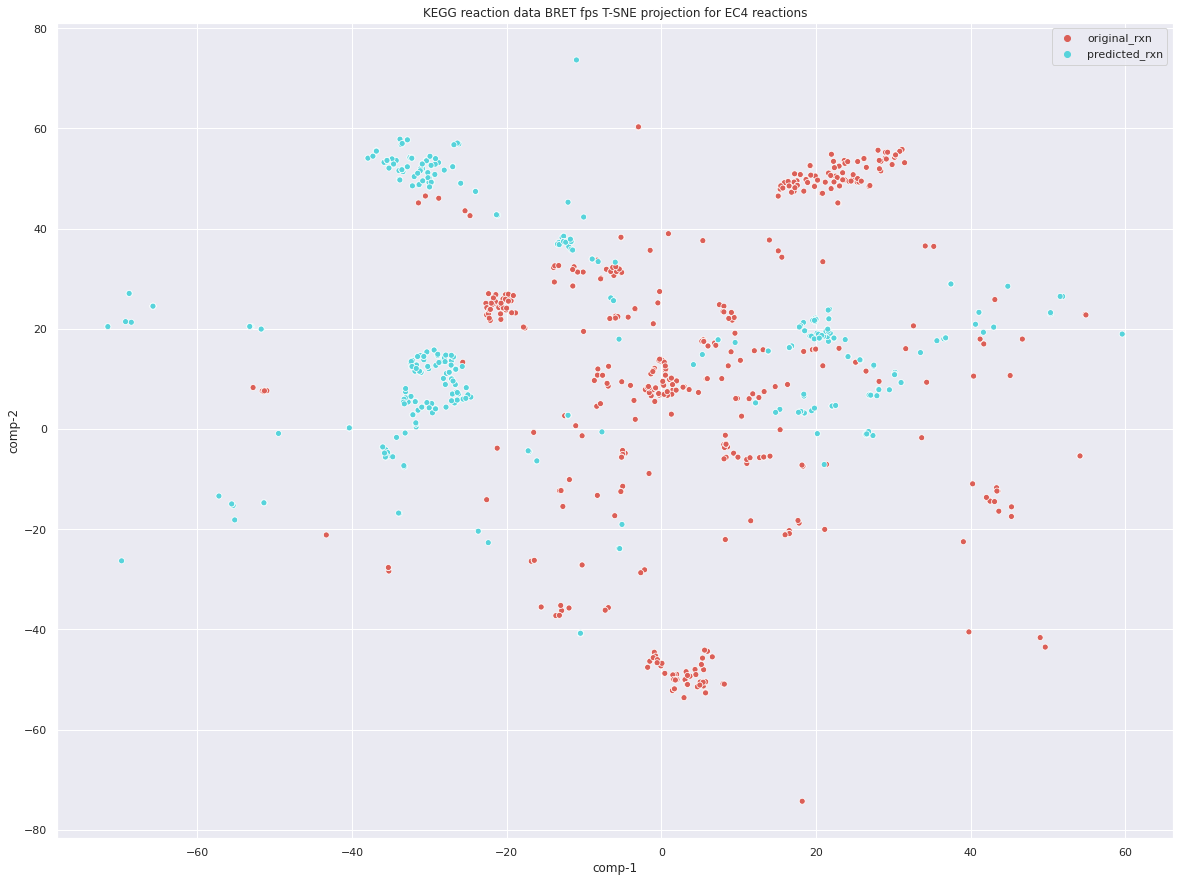

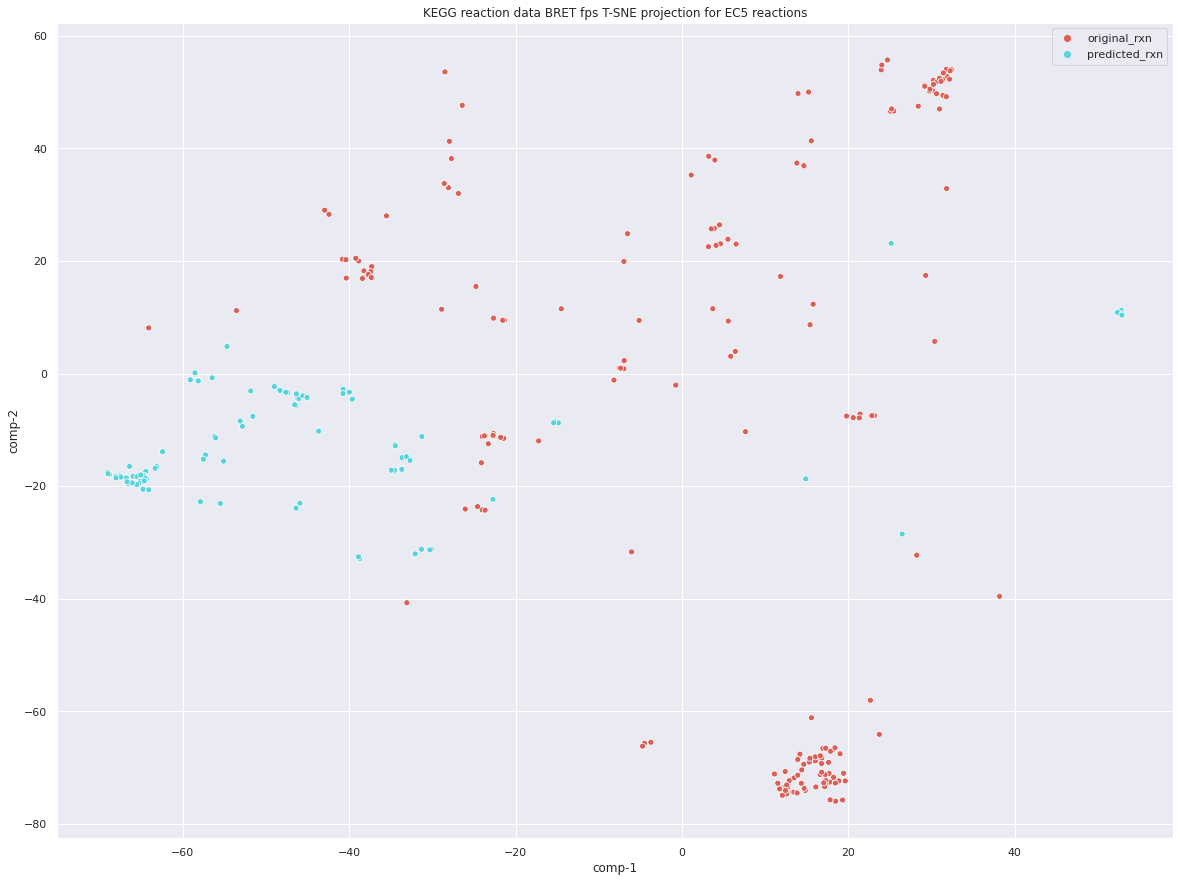

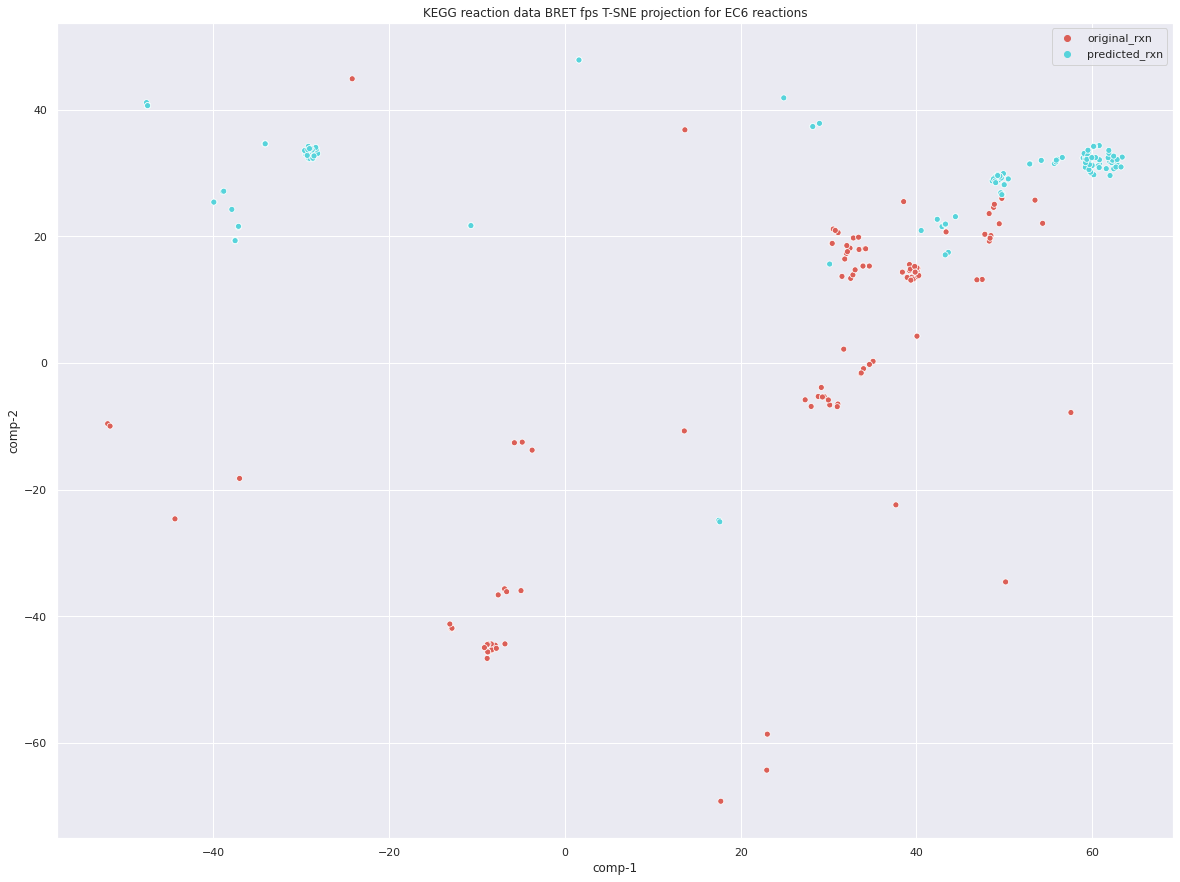

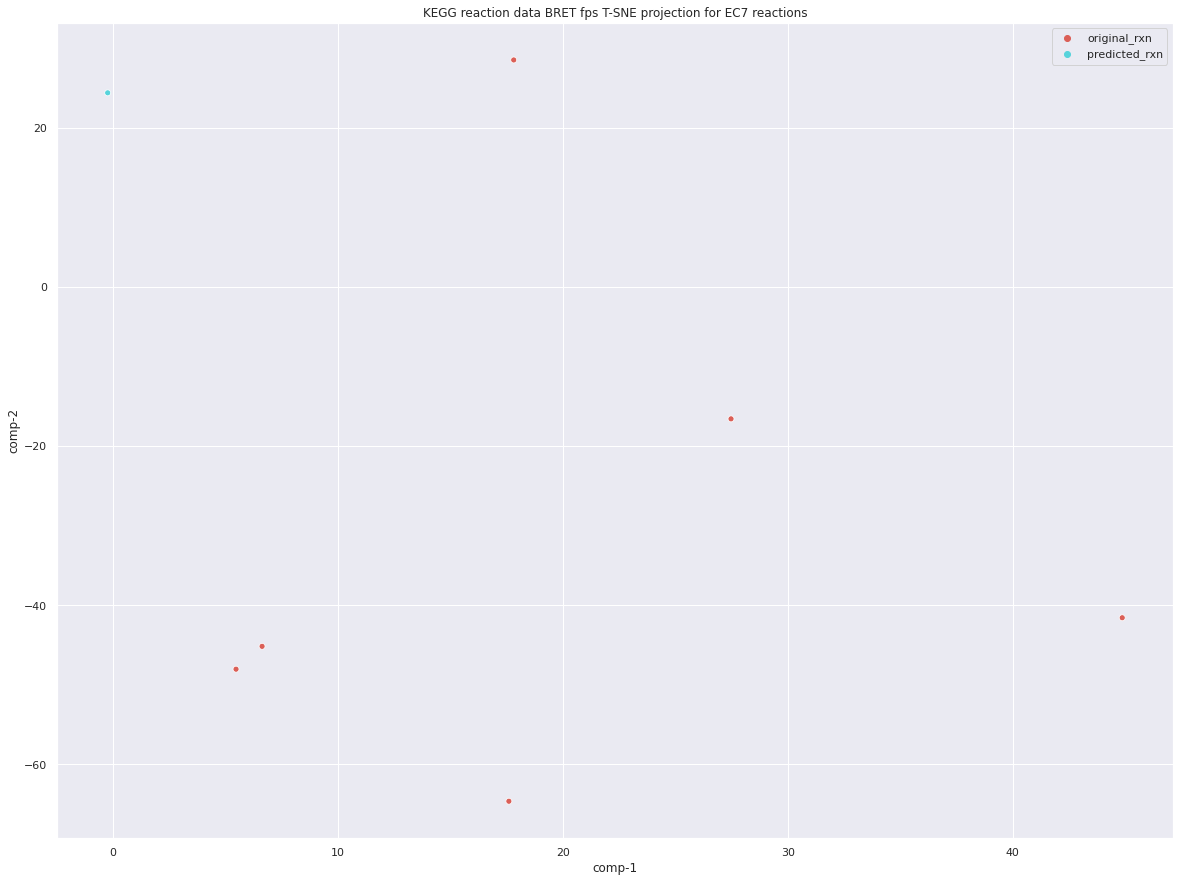

In [284]:
for i in range(1,8):
    classes = [i]
    select_one_class(classes)
    plt.show()